<a href="https://colab.research.google.com/github/dronnet/hackathons/blob/main/repetit_11_01_2024_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Хакатон по https://repetit.ru/

Заказчик - Сервис Repetit.ru (http://repetit.ru/) работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%.
Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.

Цель: Построение ML-продукта для оптимизации классификации заявок на оплату для сервиса Repetit.ru (http://repetit.ru/)


-- --
❓ Что важно учесть?

1 — Будьте готовы поработать с реальными «сырыми» данными и уделить время их предобработке
2 — Не стесняйтесь задавать любые вопросы (письменно или на встречах) — наша цель помочь вам сделать задачу качественно и в срок
3 — ТЗ проекта вы сможете найти здесь (https://docs.google.com/document/d/1Y6wMp6C_ed1V4XbaF0GWbljcLro6cOSvFDiNAK_4gc8/edit#heading=h.8mpy01npltsm). Пожалуйста, внимательно ознакомьтесь перед откликом.

❓Рекомендуемые инструменты для реализации задачи

Python, Pandas, Numpy, Matplotlib, NLP (Creating embeddings for text), Scikit-learn, LightGBM, CatBoost, Docker container


# Техническое задание по проекту: Построение ML-продукта для оптимизации классификации заявок на оплату для сервиса Repetit.ru

## Содержание

- Заказчик
- Описание проекта
- Описание данных
- Используемый стек технологий
- Срок реализации
- План реализации
- Ожидаемый результат
- Полезные материалы


## Заказчик

Сервис по подбору репетиторов Repetit.ru

## Описание проекта
Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%.
Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.

###Задачи:

Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом. Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет. Оценка качества модели будет производиться с использованием precision и ROC-AUC.





### Возможные проблемы:

#### Проблема обучения модели
Как обучать модель, если у нас нет данных о только поступивших заявках, а есть только те, по которым уже были совершены куча действий?

Вариант решения
Отобрать признаки не поддающиеся изменениям во времени и известны на момент подачи заявки.

#### Проблема дублей

Самое сложное в нашей БД — это “дубли заявок”. На одну заявку может быть только один “назначенный репетитор”, то есть репетитор, с которым случился обмен контактами. Если клиент хочет ещё с одним репетитором обменяться номерами, то мы создаём дубль заявки и назначаем репетитора на дубль, при этом в дубле создаётся запись original_order_id = номер первой заявки. Иногда консультанты создают новую заявку сами и не указывают, что эта заявка — дубль.
Для чего создается вторая заявка (дубль)? На случай, если репетитор не устраивает, не доступен или хочется просто получить ещё один номер или если сильно меняются условия заявки после уточнения консультантом.
Стоит помечать всю группу дублей таргетом - оплачено, если хотя бы один из дублей оплачен.
Если обучаться на группах, то это будет не совсем корректно, поскольку в рабочих условиях мы не знаем наперед будет ли у заявки дубль или группа дублей.
Сколько заявок имеют такой же original_order_id = сколько дублей. какой последний это тот, у кого номер айди самый последний, напрмер.
#### Проблема постоянных изменений в заявке

Если заявка только только что создана, то мы знаем только параметры фильтров, по которым клиент ищет репетитора и подходящих репетиторов на заявку. Проходит 1-180 минут и за это время может произойти очень многое, что критично скажется на заявке: появятся отклики (requests) репетиторов, клиент выберет репетиторов из каталога (prefered teachers), возможно даже создастся дубль заявки и с одним из репетиторов произойдет обмен номерами, консультант позвонит по заявке и уточнит требования к репетитору.
Если прогонять через модель один раз на свежую заявку, то мы получим довольно низкую метрику precision. Но хочется, чтобы с каждым новым действием по заявке метрика росла.
Варианты решения
сделать одну модель, которая будет считать вероятность оплаты заявки и запускать её каждые 15 минут для оценки всех заявок в работе.
сделать несколько моделей: для только что поступившей заявки, для заявки с откликами и желаемыми, для заявки с дублями и т.д.

## Описание данных

#### Заявки (orders*.csv)  
order_date - дата создания   
subject_id - предмет  
purpose - цель занятий  
lesson_price - цена  
lesson_duration - желаемая проодолжительность урока  
home_metro_id - ближайшее метро  
add_info - доп инфо  
start_date  
working_teacher_id  
status_id - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)  
comments     
amount_to_pay  
planned_lesson_number - клиент планирует N занятий  
first_lesson_date - дата 1 занятия  
coef - коэффициент  
creator_id - кто создал заявку (id сотрудника или клиента)  
pupil_category_new_id - возраст ученика  
lessons_per_week - занятий а неделю  
minimal_price  
teacher_sex - пол репетитора  
teacher_experience_from - опыт репетитора от  
teacher_experience_to- опыт репетитора до  
lesson_place_new - онлайн, у ученика, у учителя  
pupil_knowledgelvl -уровень знаний ученика  
teacher_age_from - желаемый возраст репеитора от  
teacher_age_to - желаемый возраст репеитора от  
chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно  
no_teachers_available - на заявку нет подходящих репов  
source_id - где создана заявка (какая часть сайта, не регион)  
original_order_id - дублем какой заявки является эта заявка  
client_id - айди клиента  
additional_status_id  
max_metro_distance - максимально готов ехать от метро  
estimated_fee   
payment_date  
test_group - аб тесты  
is_display_to_teachers - хочет ли клиент получать отклики
репетиторов  

#### Репетиторы (teacher_info.csv)   
- date_update  
- reg_date  
- birth_date  
- teaching_start_date  
- user_id - айди  
- is_email_confirmed  
- is_home_lessons  
- is_external_lessons  
- external_comments  
- lesson_duration - продолжит урока  
- lesson_cost - стоимость урока  
- status_id  
- status_relevant_date  
- status_school_id  
- status_college_id  
- status_display  
- russian_level_id  
- home_country_id  
- education  
- information  
- is_confirmed  
- is_display - показывается в каталоге  
- rating_id   
- rating - рейтинг  
- comments  
- rules_confirmed_date  
- last_visited - послеждний визит  
- is_pupils_needed - открыт для заявок  
- is_cell_phone_confirmed
- effective_rating - какой-то еще рейтинг
- area_id
- registrar_id
- pupil_needed_date
- sex
- amount_to_pay - долг
- is_remote_lessons
- remote_comments
- show_on_map
- send_mailing
- send_suitable_orders
- rating_for_users - рейтинг 2
- rating_for_admin - рейтинг 3
- passport_id
- is_edited
- orders_allowed - разрешено назначать на заявки
- display_days
- verification_status_id
- is_individual
- partner_id
- star_rating - рейтинг 4
- rating_for_users_yesterday - рейтинг вчера
- review_num - отзывы
- relevance_date
- is_display_at_partners
- video_presentation_id - есть видеопрезентация
- status_institution_id
- Free_time_relevance_date

#### Подходящие по фильтру репетиторы (suitable_teachers.csv)

- tteacher_id - id репетитора
- order_id - id заявки
- contact_result    
- enable_auto_assign - доступен ли репетитор к работе или заблокирован (может ли репетитора назначить консультант и может ли он сам назначиться) (значение известно на момент подачи заявки)
- enable_assign - доступен ли репетитор к работе или заблокирован (может ли репетитора назначить консультант и может ли он сам назначиться) (значение известно на момент подачи заявки)

#### Желаемые репетиторы (prefered_teachers_order_id.csv)

Репетиторы, которых клиент выбрал клиент.

- tteacher_id - id репетитора
- order_id - id заявки
- -Используемый стек технологий
- Python
- Pandas
- Numpy
- Matplotlib
- Scikit-learn
- LightGBM
- CatBoost
- Docker container
- Срок реализации
- Срок реализации проекта - 3 недели с момента старта Мастерской

## План реализации:

- загрузка и ознакомление с данными,
- предварительная обработка и отбор полезных признаков,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- отбор финального набора обучающих признаков.
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.
- подготовка отчета по исследованию

## Ожидаемый результат


1. Тетрадь с решением задачи (описание проекта, исследование, методы решения)
2. Задача со звездочкой №1: сервис в виде Docker контейнера или Python модуль в виде функции
3. Задача со звездочкой №2: Решить проблему постоянных изменений в заявке

## Полезные материалы

CatBoost - https://habr.com/ru/companies/otus/articles/778714/  
Docker container - https://www.youtube.com/watch?v=eAXjeh5MRVU  


## библиотеки  и прочее

In [ ]:
!pip install optuna -q
!pip install catboost -q
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import os
#import json
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import optuna
import shap

from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score

import joblib

In [ ]:
# constants
STATE = 33443

#Путь к каталогу с данными
DATA_PATH = 'repetit_ru/'
DATA_PATH_GOOGLE = '/content/drive/MyDrive/Peton/hakaton_repetit_ru/'

## загрузка и ознакомление с данными

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#прочитаем данные orders
patch = os.path.join(DATA_PATH_GOOGLE, 'datasets/orders.feather')

#orders = pd.read_feather(patch)
orders = pl.read_ipc(patch, use_pyarrow = True,)

orders.head()

id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,__index_level_0__
i32,str,f32,str,i32,i32,str,f32,str,str,f32,i32,str,f32,str,i32,str,f32,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,i32,f32,i32,f32,f32,str,str,i8,i64
2294054,"""2022-11-01 00:…",1.0,null,0,60,null,null,null,null,null,16,null,null,"""0""",0,null,null,null,0,0,3,0,0,0,0,0,0,0,0,18,2.294e6,675960,7.0,null,null,null,1,0
2294055,"""2022-11-01 00:…",1.0,null,0,60,null,null,null,null,null,7,""" 01.11.2022 11…",null,"""0""",0,null,null,null,0,0,3,0,0,0,0,0,0,0,0,18,2.294e6,675960,7.0,null,null,null,1,1
2294056,"""2022-11-01 00:…",21.0,"""Разделы: начер…",800,60,null,null,"""Место проведен…","""2022-11-01 10:…",143480.0,16,null,null,"""0""",7,null,null,14.0,2,0,3,0,0,4,0,0,0,0,0,23,null,1024439,10.0,null,"""1200""",null,1,2
2294057,"""2022-11-01 00:…",8.0,"""Разделы: школ…",700,60,null,null,"""Место проведен…","""2022-11-01 00:…",236392.0,16,null,null,"""0""",10,null,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2.293804e6,1024340,17.0,null,"""2310""",null,1,3
2294058,"""2022-11-01 00:…",8.0,null,0,60,null,122.0,null,null,null,16,"""Тестовая групп…",null,"""0""",0,null,null,null,0,0,0,0,0,2,0,0,0,0,0,16,null,1024440,5.0,null,null,null,1,4


### Запись небольшой части исходного датафрейма для тестирования приложения Docker

In [ ]:
#запись на диск небольшого датафрейма для тестирования docker + streamlit
orders_sample = orders.sample(n=1000, seed=STATE)
path = os.path.join(DATA_PATH_GOOGLE, 'orders_sample.feather')
orders_sample.write_ipc(path)


In [ ]:
orders.shape

(1191861, 39)

In [ ]:
orders.describe()

describe,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,__index_level_0__
str,f64,str,f64,str,f64,f64,str,f64,str,str,f64,f64,str,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64
"""count""",1.191861e6,"""1191861""",1.181529e6,"""1025351""",1.191861e6,1.191861e6,"""31""",642447.0,"""1044688""","""705578""",705988.0,1.191861e6,"""341468""",4.0,"""1191861""",1.191861e6,"""166571""",579698.0,1.03247e6,1.191861e6,1.191861e6,1.191861e6,1.191861e6,1.191861e6,1.191861e6,1.191861e6,1.191861e6,1.191861e6,1.191861e6,1.191861e6,1.191861e6,582588.0,1.191861e6,1.042385e6,13518.0,"""747152""","""129665""",1.191861e6,1.191861e6
"""null_count""",0.0,"""0""",10332.0,"""166510""",0.0,0.0,"""1191830""",549414.0,"""147173""","""486283""",485873.0,0.0,"""850393""",1.191857e6,"""0""",0.0,"""1025290""",612163.0,159391.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,609273.0,0.0,149476.0,1.178343e6,"""444709""","""1062196""",0.0,0.0
"""mean""",2.3405e6,null,21.387354,null,2019.465871,71.867543,null,NaN,null,null,NaN,24.363516,null,NaN,null,19.520758,null,NaN,22.868477,14.233463,212.986802,13.298901,12.686752,12.111352,14.075896,11.60722,19.555055,28.635404,0.022371,0.090835,28.770307,NaN,962518.00008,NaN,NaN,null,null,0.964168,147667.085767
"""std""",344556.254559,null,6157.333008,null,916334.053366,6130.493786,null,NaN,null,null,NaN,6130.577894,null,NaN,null,6130.586317,null,NaN,6586.819824,6130.59517,11111.445555,6130.596764,6130.598421,6130.604559,6130.595509,6130.599822,6130.599873,6131.385295,0.147887,0.287375,6130.570367,NaN,217718.754278,NaN,NaN,null,null,0.185872,120520.662764
"""min""",1.742636e6,"""0029-07-18 05:…",1.0,""" ​Категория у…",0.0,0.0,"""не важно""",1.0,""" ""","""0029-07-18 05:…",33.0,1.0,""" 01.02.2022 10…",3.211265e6,"""0""",0.0,"""0029-07-18 05:…",45.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-40.0,-110.0,0.0,0.0,0.0,263.0,1.0,1.0,0.0,"""0""","""0029-07-18 05:…",0.0,0.0
"""25%""",2.041441e6,null,3.0,null,500.0,60.0,null,228.0,null,null,100913.0,7.0,null,3.211265e6,null,10.0,null,304610.0,8.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.0,2.022765e6,868083.0,7.0,30.0,null,null,1.0,47477.0
"""50%""",2.341556e6,null,8.0,null,1000.0,60.0,null,644.0,null,null,169516.0,16.0,null,3.342337e6,null,10.0,null,780665.0,10.0,3.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,16.0,2.318886e6,989633.0,10.0,30.0,null,null,1.0,101185.0
"""75%""",2.63872e6,null,13.0,null,1500.0,60.0,null,1146.0,null,null,234329.0,16.0,null,3.342337e6,null,10.0,null,971566.0,12.0,4.0,0.0,3.0,1.0,0.0,4.0,0.0,20.0,40.0,0.0,0.0,23.0,2.63166e6,1.125538e6,13.0,30.0,null,null,1.0,243961.0
"""max""",3.605505e6,"""2023-11-05 23:…",3.605505e6,"""•ОФФЛАЙН : 2 р…",1.0000e9,3.605505e6,"""у ученика""",3.605505e6,"""​Требования к …","""2023-11-07 20:…",3.605505e6,3.605505e6,"""Тестовая групп…",3.605505e6,"""9990""",3.605505e6,"""2023-11-07 00:…",3.605505e6,3.605505e6,3.605505e6,1e7,3.605505e6,3.605505e6,3.605505e6,3.605505e6,3.605505e6,3.605505e6,3.605505e6,1.0,1.0,3.605505e6,3.605505e6,3.605505e6,3.605505e6,5e6,"""9998""","""2023-11-07 20:…",1.0,437216.0


In [ ]:
#поиск дубликатов
orders.is_duplicated().max()

False

In [ ]:
#поиск имён столбцов с пропусками больше определённой величины, я взял 500 тыс
orders_null_count = orders.null_count()
orders_null_count = pd.DataFrame(orders_null_count, columns=orders_null_count.columns)
col = (orders_null_count > 500_000).any()
orders_null_count = orders_null_count.loc[: , col]
orders_null_count

,lesson_place,home_metro_id,comments,prefered_teacher_id,first_lesson_date,creator_id,original_order_id,max_metro_distance,payment_date
0,1191830,549414,850393,1191857,1025290,612163,609273,1178343,1062196


#### Итак довольно много столбцов где пропусков более 500тыс. Такие столбцы я удалю

In [ ]:
#количество полов учителей
orders['teacher_sex'].n_unique()

7

In [ ]:
orders['teacher_sex'].value_counts()

teacher_sex,count
i32,u32
3605505,1
0,203697
2,392286
1,46062
3211265,2
3342337,1
3,549812


In [ ]:
#удаление строк о поле с большими цифрами
#orders = orders.filter(pl.col('teacher_sex') < 5)
#orders['teacher_sex'].value_counts()

In [ ]:
#количество предметов
orders['subject_id'].n_unique()

31

In [ ]:
(orders['subject_id'] > 37).sum()

4

In [ ]:
orders['subject_id'].drop_nulls().value_counts()

subject_id,count
f32,u32
20.0,16657
10.0,57260
36.0,5634
23.0,7289
12.0,42159
19.0,46735
7.0,16163
18.0,64310
3.211265e6,2


Итак основных предметов около 36ти штук, что похоже на правду.
предметы с огромными номерами или ошибка или ...

In [ ]:
#orders.select(pl.col('subject_id'))
orders['subject_id'].drop_nulls().hist(bin_count=10)

break_point,category,count
f64,cat,u32
0.0,"""(-inf, 0.0]""",0
360550.6,"""(0.0, 360550.6…",1181525
721101.2,"""(360550.6, 721…",0
1.0817e6,"""(721101.2, 1.0…",0
1442202.4,"""(1.0817e6, 144…",0
1.802753e6,"""(1442202.4, 1.…",0
2.1633e6,"""(1.802753e6, 2…",0
2.5239e6,"""(2.1633e6, 2.5…",0
2884404.8,"""(2.5239e6, 288…",0


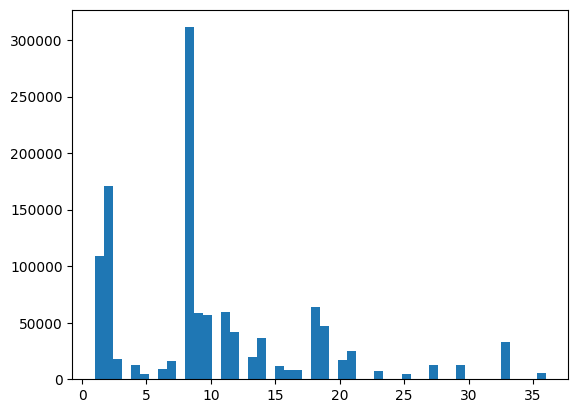

In [ ]:
#распределение предметов по типам
plt.hist(orders['subject_id'].filter(orders['subject_id'] < 40), bins=50);

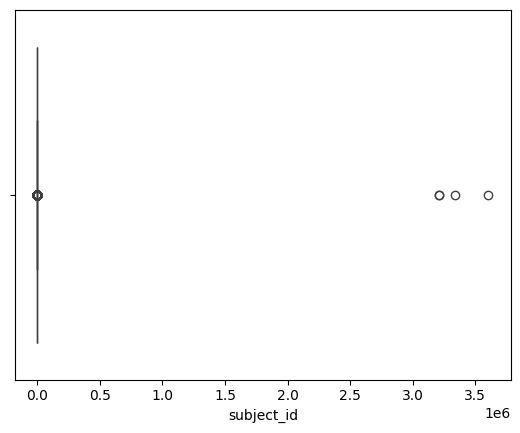

In [ ]:
sns.boxplot(x=orders['subject_id']);

In [ ]:
#количество уникальных значений по столбцам
orders.select(pl.n_unique(orders.columns))

id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,__index_level_0__
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1190961,1190749,31,294448,349,9,5,2327,609438,705034,58535,18,93506,4,1415,8,819,107754,20,11,171,7,43,68,11,8,86,109,2,2,25,314932,487595,28,35,1594,124286,2,437217


In [ ]:
#прочитаем данные prefered_teachers_order_id
patch = os.path.join(DATA_PATH_GOOGLE, 'datasets/prefered_teachers_order_id.feather')

prefered_teachers_order_id = pl.read_ipc(patch, use_pyarrow = True,)
prefered_teachers_order_id.head(10)

order_id,teacher_id
i32,i32
2469225,19663
2470455,19663
2480251,19663
2481259,19663
2483171,19663
2521084,19663
2521124,19663
2522705,19663
2558804,19663


In [ ]:
#кол-во дубликатов строк
prefered_teachers_order_id.is_duplicated().sum()

32

In [ ]:
#количество уникальных значений по столбцам
prefered_teachers_order_id.select(pl.n_unique(prefered_teachers_order_id.columns))

order_id,teacher_id
u32,u32
613990,94728


In [ ]:
#прочитаем данные suitable_teachers
patch = os.path.join(DATA_PATH_GOOGLE, 'datasets/suitable_teachers.feather')

suitable_teachers = pl.read_ipc(patch, use_pyarrow = True,)
suitable_teachers.head()

teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
i32,i32,cat,i8,i8
82583,1742711,"""Репетитор согл…",1,1
125057,1742713,"""Репетитор поло…",0,0
231211,1742713,"""Репетитор поло…",0,0
128773,1742713,"""Репетитор поло…",0,0
63019,1742713,"""Репетитор согл…",0,1


In [ ]:
suitable_teachers.shape

(20271186, 5)

In [ ]:
#кол-во дубликатов строк
suitable_teachers.is_duplicated().sum()

98

In [ ]:
#количество уникальных значений по столбцам
suitable_teachers.select(pl.n_unique(suitable_teachers.columns))

teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
u32,u32,u32,u32,u32
145944,842019,10867,2,2


In [ ]:
#прочитаем данные teachers_info
patch = os.path.join(DATA_PATH_GOOGLE, 'datasets/teachers_info.feather')

teachers_info = pl.read_ipc(patch, use_pyarrow = True,)
teachers_info.head()

id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,…,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
i32,cat,cat,cat,cat,i32,i8,i8,i8,cat,i16,i32,i8,cat,f32,f32,i8,i8,i16,cat,i8,cat,i16,i32,i8,cat,f32,f32,i8,i8,i16,cat,i8,cat,i16,i32,i8,…,cat,cat,i8,i8,i8,i32,cat,cat,cat,f32,i8,f32,i8,cat,i8,i16,i8,cat,i8,i8,i8,f32,f32,f32,i8,i8,f32,i8,f32,cat,f32,f32,i16,cat,i8,f32,cat
33,"""2023-11-07 14:…","""2007-12-24 19:…","""1983-06-05 00:…","""1989-09-01 00:…",45,0,0,0,null,60,1000,4,null,null,null,0,5,7,"""[p]&nbsp;[/p][…",1,null,60,1000,4,null,null,null,0,5,7,"""[p]&nbsp;[/p][…",1,null,60,1000,4,…,"""/teachers/33/p…","""[p]&nbsp;[/p][…",1,1,15,5,"""Швачко М.Н. 15…","""2016-02-12 21:…","""2022-10-24 16:…",1.0,0,4.6796875,1,null,1,500,1,null,0,1,0,1138.0,237.5,null,1,0,492.0,1,null,null,4.5,1138.0,6,"""2022-05-16 18:…",0,3702.0,"""2023-11-06 14:…"
46,"""2023-01-19 17:…","""2007-12-24 19:…","""1980-02-12 00:…","""2003-09-01 00:…",63,0,1,1,null,60,500,5,null,null,null,1,5,7,null,1,null,60,500,5,null,null,null,1,5,7,null,1,null,60,500,5,…,"""/teachers/46/p…",null,1,0,4,-3,null,"""2014-08-12 00:…",null,1.0,0,0.0,1,null,3,0,0,null,0,1,1,25.0,0.0,null,1,1,0.0,1,null,null,4.300781,25.0,0,"""2017-01-01 00:…",1,null,null
51,"""2023-05-25 09:…","""2007-12-24 19:…","""1965-04-30 00:…","""1988-09-01 00:…",68,0,0,0,null,60,1500,5,null,null,null,1,5,7,"""[p]Готовлю к Е…",1,null,60,1500,5,null,null,null,1,5,7,"""[p]Готовлю к Е…",1,null,60,1500,5,…,"""/teachers/51/p…","""[p]Готовлю к Е…",1,0,16,6,null,"""2016-04-06 16:…","""2022-09-26 09:…",1.0,0,6.0,1,null,2,0,1,"""Только удаленн…",0,1,0,300.0,0.0,null,1,1,2182.0,3,0.0,null,4.300781,300.0,0,"""2017-01-01 00:…",0,null,null
52,"""2023-01-19 10:…","""2007-12-24 19:…","""1988-07-06 00:…","""2006-09-01 00:…",69,0,0,1,"""Ближайший райо…",60,1000,5,null,null,null,1,5,7,null,1,"""Ближайший райо…",60,1000,5,null,null,null,1,5,7,null,1,"""Ближайший райо…",60,1000,5,…,"""/teachers/52/p…",null,1,1,16,6,null,"""2014-08-12 00:…","""2020-04-03 15:…",0.0,0,11.289062,1,"""2019-12-31 00:…",2,0,1,null,0,1,1,135.0,0.0,null,1,1,2084.0,1,0.0,null,5.0,135.0,2,"""2020-04-01 01:…",1,null,null
54,"""2023-01-19 16:…","""2007-12-24 19:…","""1985-09-30 00:…","""2004-01-01 00:…",70,0,0,1,"""Выезд в удобно…",45,400,5,null,null,null,1,5,7,"""4 года репетит…",1,"""Выезд в удобно…",45,400,5,null,null,null,1,5,7,"""4 года репетит…",1,"""Выезд в удобно…",45,400,5,…,"""/teachers/54/p…","""4 года репетит…",1,0,4,-3,"""21,01,2008 Не …","""2014-08-12 00:…",null,1.0,0,-5.0,1,null,3,0,0,null,0,1,1,50.0,0.0,null,0,1,0.0,1,null,null,4.300781,50.0,0,"""2017-01-01 00:…",1,null,null


In [ ]:
teachers_info.shape

(307972, 80)

In [ ]:
#кол-во дубликатов строк
teachers_info.is_duplicated().sum()

0

In [ ]:
#количество уникальных значений по столбцам
teachers_info.select(pl.n_unique(teachers_info.columns))

id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,…,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
307972,307079,307729,22247,776,307972,2,2,2,26083,101,324,6,1576,3596,852,2,6,147,121898,2,26083,101,324,6,1576,3596,852,2,6,147,121898,2,26083,101,324,6,…,179959,121898,2,2,27,26,36903,222686,235806,3,2,2338,91,4572,4,3,2,2603,2,2,2,5065,5699,1324,2,2,3890,5,3,6063,29,5061,130,222907,2,2908,1706


In [ ]:
teachers_info['sex'].value_counts()

sex,count
i8,u32
2,225871
1,75085
0,214
3,6802


выводы по учителям:
- всего в базе 307 972 учителя
- судя по разным id, все учителя уникальные
- не принципиально, но опять же 4 разных пола учителей наводят на странные мысли
-

## предварительная обработка и отбор полезных признаков

In [ ]:
#удаление строк с предметами с большими номерами и фильтрация по полу (остаются только те у кого пол < 5)
orders = orders.filter(
    (pl.col('subject_id') < 40) |
    (pl.col('teacher_sex') < 5)
     )
orders.shape

(1191857, 39)

In [ ]:
#добавление колонки target.
#1 если есть значения 6 или 13 и 0 - если любое другое значение
#●status_id - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)


orders = orders.with_columns(
        pl.when((pl.col('status_id') == 13) | (pl.col('status_id') == 6))
        .then(1)
        .otherwise(0)
        .alias('target')
    )

In [ ]:
orders['target'].value_counts()

target,count
i32,u32
1,123630
0,1068227


In [ ]:
orders['target'].mean()

0.10372888693861763

In [ ]:
orders['target'].is_null().sum()

0

In [ ]:
#группировка по original_order_id с целью:
  #выяснить заявку "родителя"
  #посчитать количество заявок-копий
  #поставить признак оплачена/нет хоть одна из заявок оплачена (всем начальным заявкам присвоить 1 если хоть одна из группы оплачена)
  #посчитать количество уникальных учителей на все копии
  #

orders_groupby = orders.group_by('original_order_id').agg([pl.count('id'),
                                                          pl.max('target').alias('target_group'),
                                                          pl.n_unique('working_teacher_id').alias('n_unique_teacher'),
                                                          #pl.count('working_teacher_id').alias('count_teacher'),
                                                          #pl.mean('lesson_price')
                                         ]) \
                                         .drop_nulls() \
                                         .with_columns(pl.col('original_order_id').cast(pl.Int32))


orders_groupby.sort(#by='id',
                    by='n_unique_teacher',
                    descending=True)

original_order_id,id,target_group,n_unique_teacher
i32,u32,i32,u32
2509516,83,0,83
2808757,34,1,33
2500332,38,1,32
2831339,29,1,29
2703943,34,0,29
2543733,32,1,27
2579103,29,0,27
2836002,25,1,24
2758430,24,1,24


In [ ]:
#балланс по целевому признаку
orders_groupby['target_group'].mean()

0.12708301580043693

In [ ]:
#количество заявок где назначенных учителей больше одного
orders_groupby['n_unique_teacher'].filter(orders_groupby['n_unique_teacher'] > 1).shape

(99185,)

#### около 100 тысяч записей с разными учителями.
То есть, если взять одну заявку и все её дубли, то получается что на такие дубли могут быть назначены разные учителя и таких зявок около 100 тыс,  с разными учителями.
-- --
Отсюда получается что к аггрегированной заявке нельзя "приджойнить" данные учителя, потому как учителя разные.

Есть идея приджойнить некие аггрегированные параметры по учителям, но на мне не нравится. Разве имеет смысл вычислять средний возраст учителей или средний пол?

А очень хотелось бы присоединить.
-- --
Принимаю решение учителей не присоединять.

In [ ]:
#присоединение группированной таблицы к основной
orders = orders.join(orders_groupby, left_on='id', right_on='original_order_id', how='left')
orders.shape

(1191857, 43)

In [ ]:
orders.head(3)

id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,__index_level_0__,target,id_right,target_group,n_unique_teacher
i32,str,f32,str,i32,i32,str,f32,str,str,f32,i32,str,f32,str,i32,str,f32,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,i32,f32,i32,f32,f32,str,str,i8,i64,i32,u32,i32,u32
2294054,"""2022-11-01 00:…",1.0,null,0,60,null,null,null,null,null,16,null,null,"""0""",0,null,null,null,0,0,3,0,0,0,0,0,0,0,0,18,2.294e6,675960,7.0,null,null,null,1,0,0,null,null,null
2294055,"""2022-11-01 00:…",1.0,null,0,60,null,null,null,null,null,7,""" 01.11.2022 11…",null,"""0""",0,null,null,null,0,0,3,0,0,0,0,0,0,0,0,18,2.294e6,675960,7.0,null,null,null,1,1,0,null,null,null
2294056,"""2022-11-01 00:…",21.0,"""Разделы: начер…",800,60,null,null,"""Место проведен…","""2022-11-01 10:…",143480.0,16,null,null,"""0""",7,null,null,14.0,2,0,3,0,0,4,0,0,0,0,0,23,null,1024439,10.0,null,"""1200""",null,1,2,0,1,0,1


In [ ]:
#проставление целевого признака заявке если есть оплата хоть у одной копии или у оригинала
orders = orders.with_columns(
        pl.when((pl.col('target') == 1) | (pl.col('target_group') == 1))
        .then(1)
        .otherwise(0)
        .alias('target_1')
    )
orders.head(3)

id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,__index_level_0__,target,id_right,target_group,n_unique_teacher,target_1
i32,str,f32,str,i32,i32,str,f32,str,str,f32,i32,str,f32,str,i32,str,f32,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,i32,f32,i32,f32,f32,str,str,i8,i64,i32,u32,i32,u32,i32
2294054,"""2022-11-01 00:…",1.0,null,0,60,null,null,null,null,null,16,null,null,"""0""",0,null,null,null,0,0,3,0,0,0,0,0,0,0,0,18,2.294e6,675960,7.0,null,null,null,1,0,0,null,null,null,0
2294055,"""2022-11-01 00:…",1.0,null,0,60,null,null,null,null,null,7,""" 01.11.2022 11…",null,"""0""",0,null,null,null,0,0,3,0,0,0,0,0,0,0,0,18,2.294e6,675960,7.0,null,null,null,1,1,0,null,null,null,0
2294056,"""2022-11-01 00:…",21.0,"""Разделы: начер…",800,60,null,null,"""Место проведен…","""2022-11-01 10:…",143480.0,16,null,null,"""0""",7,null,null,14.0,2,0,3,0,0,4,0,0,0,0,0,23,null,1024439,10.0,null,"""1200""",null,1,2,0,1,0,1,0


In [ ]:
#
orders.filter(pl.col('working_teacher_id') == pl.col('prefered_teacher_id'))


id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,__index_level_0__,target,id_right,target_group,n_unique_teacher,target_1
i32,str,f32,str,i32,i32,str,f32,str,str,f32,i32,str,f32,str,i32,str,f32,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,i32,f32,i32,f32,f32,str,str,i8,i64,i32,u32,i32,u32,i32


In [ ]:
orders['max_metro_distance'].is_null().sum()

1178343

In [ ]:
#удаление лишних столбцов
orders = orders.drop('add_info',
                     'working_teacher_id',
                     'comments',
                     'prefered_teacher_id',
                     'creator_id',
                     'source_id',
                     'client_id',
                     'additional_status_id',
                     '__index_level_0__',
                     'target',
                     'id_right',
                     'target_group',

                     )

In [ ]:
#удаление строк с дублями заявок, где в столбце 'original_order_id' есть номер та строка удаляется.
# или, отфильтровываются только те строки у которых 'original_order_id' == NaN
#То есть такая строка является дублем
orders = orders.filter(
    pl.col('original_order_id').is_null()
     )
orders.shape

(609273, 32)

In [ ]:
orders.head()

id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,start_date,status_id,amount_to_pay,planned_lesson_number,first_lesson_date,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,n_unique_teacher,target_1
i32,str,f32,str,i32,i32,str,f32,str,i32,str,i32,str,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,f32,f32,str,str,i8,u32,i32
2294056,"""2022-11-01 00:…",21.0,"""Разделы: начер…",800,60,null,null,"""2022-11-01 10:…",16,"""0""",7,null,14.0,2,0,3,0,0,4,0,0,0,0,0,null,null,"""1200""",null,1,1,0
2294058,"""2022-11-01 00:…",8.0,null,0,60,null,122.0,null,16,"""0""",0,null,null,0,0,0,0,0,2,0,0,0,0,0,null,null,null,null,1,null,0
2294059,"""2022-11-01 00:…",3.0,null,0,60,null,464.0,null,16,"""0""",0,null,null,0,0,3,0,0,0,0,0,0,0,0,null,null,null,null,1,1,0
2294064,"""2022-11-01 00:…",33.0,null,0,60,null,null,null,16,"""0""",0,null,null,0,0,3,0,0,0,0,0,0,0,0,null,null,null,null,1,null,0
2294071,"""2022-11-01 00:…",21.0,"""Разделы: орато…",3000,60,null,null,"""2022-11-01 15:…",16,"""0""",10,null,14.0,5,2000,3,0,0,4,0,0,0,0,0,null,null,"""0""",null,1,1,0


In [ ]:
#поиски дубликатов строк
orders.is_duplicated().sum()

1104

In [ ]:
#удаление дубликатов
orders = orders.filter(
    ~orders.is_duplicated()
     )
orders.shape


(608169, 32)

In [ ]:
#количество дат начинающихся с 20. Например 2022, 2007 и т.д.

orders.filter(pl.col('start_date').str.contains(r"^20")).shape

(405630, 32)

In [ ]:
col = 'target_1'
orders[col].n_unique(), orders[col].is_null().sum()

(2, 0)

In [ ]:
#замена типа данных в столбце 'amount_to_pay' на Float64
orders = orders.with_columns(
    pl.col('amount_to_pay')
    .str.replace(',', '.')
    .cast(pl.Float64)
    )


In [ ]:
#удаление лишних столбцов
orders = orders.drop('id',
                     'order_date',
                     'purpose',
                     'lesson_place',
                     'home_metro_id',
                     'start_date',
                     'status_id',
                     'first_lesson_date',
                     'original_order_id',
                     'max_metro_distance',
                     'estimated_fee',
                     'payment_date',
                     #'n_unique_teacher', #заменить пропуски на 1
                     'amount_to_pay'

                     )
orders.shape

(608169, 19)

In [ ]:
orders.head(10)

subject_id,lesson_price,lesson_duration,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,n_unique_teacher,target_1
f32,i32,i32,i32,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,i8,u32,i32
21.0,800,60,7,14.0,2,0,3,0,0,4,0,0,0,0,0,1,1,0
8.0,0,60,0,null,0,0,0,0,0,2,0,0,0,0,0,1,null,0
3.0,0,60,0,null,0,0,3,0,0,0,0,0,0,0,0,1,1,0
33.0,0,60,0,null,0,0,3,0,0,0,0,0,0,0,0,1,null,0
21.0,3000,60,10,14.0,5,2000,3,0,0,4,0,0,0,0,0,1,1,0
8.0,1500,60,10,9.0,2,0,3,0,0,1,0,0,0,0,0,1,1,0
9.0,1500,60,1,14.0,2,0,3,0,0,2,0,0,0,0,0,1,1,0
8.0,1000,90,10,11.0,5,0,3,1,0,4,0,20,50,0,0,1,3,1
8.0,400,60,10,10.0,4,300,3,1,0,4,0,0,0,0,0,1,1,0


In [ ]:
#замена пропусков n_unique_teacher - количество уникальных учителей на 1
orders = orders.with_columns(pl.col('n_unique_teacher').fill_null(1))

In [ ]:
#удаление строк с пропусками
orders = orders.drop_nulls()
orders.shape

(566843, 19)

In [ ]:
#количество пропусков по каждому столбцу
orders.null_count()

subject_id,lesson_price,lesson_duration,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,n_unique_teacher,target_1
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


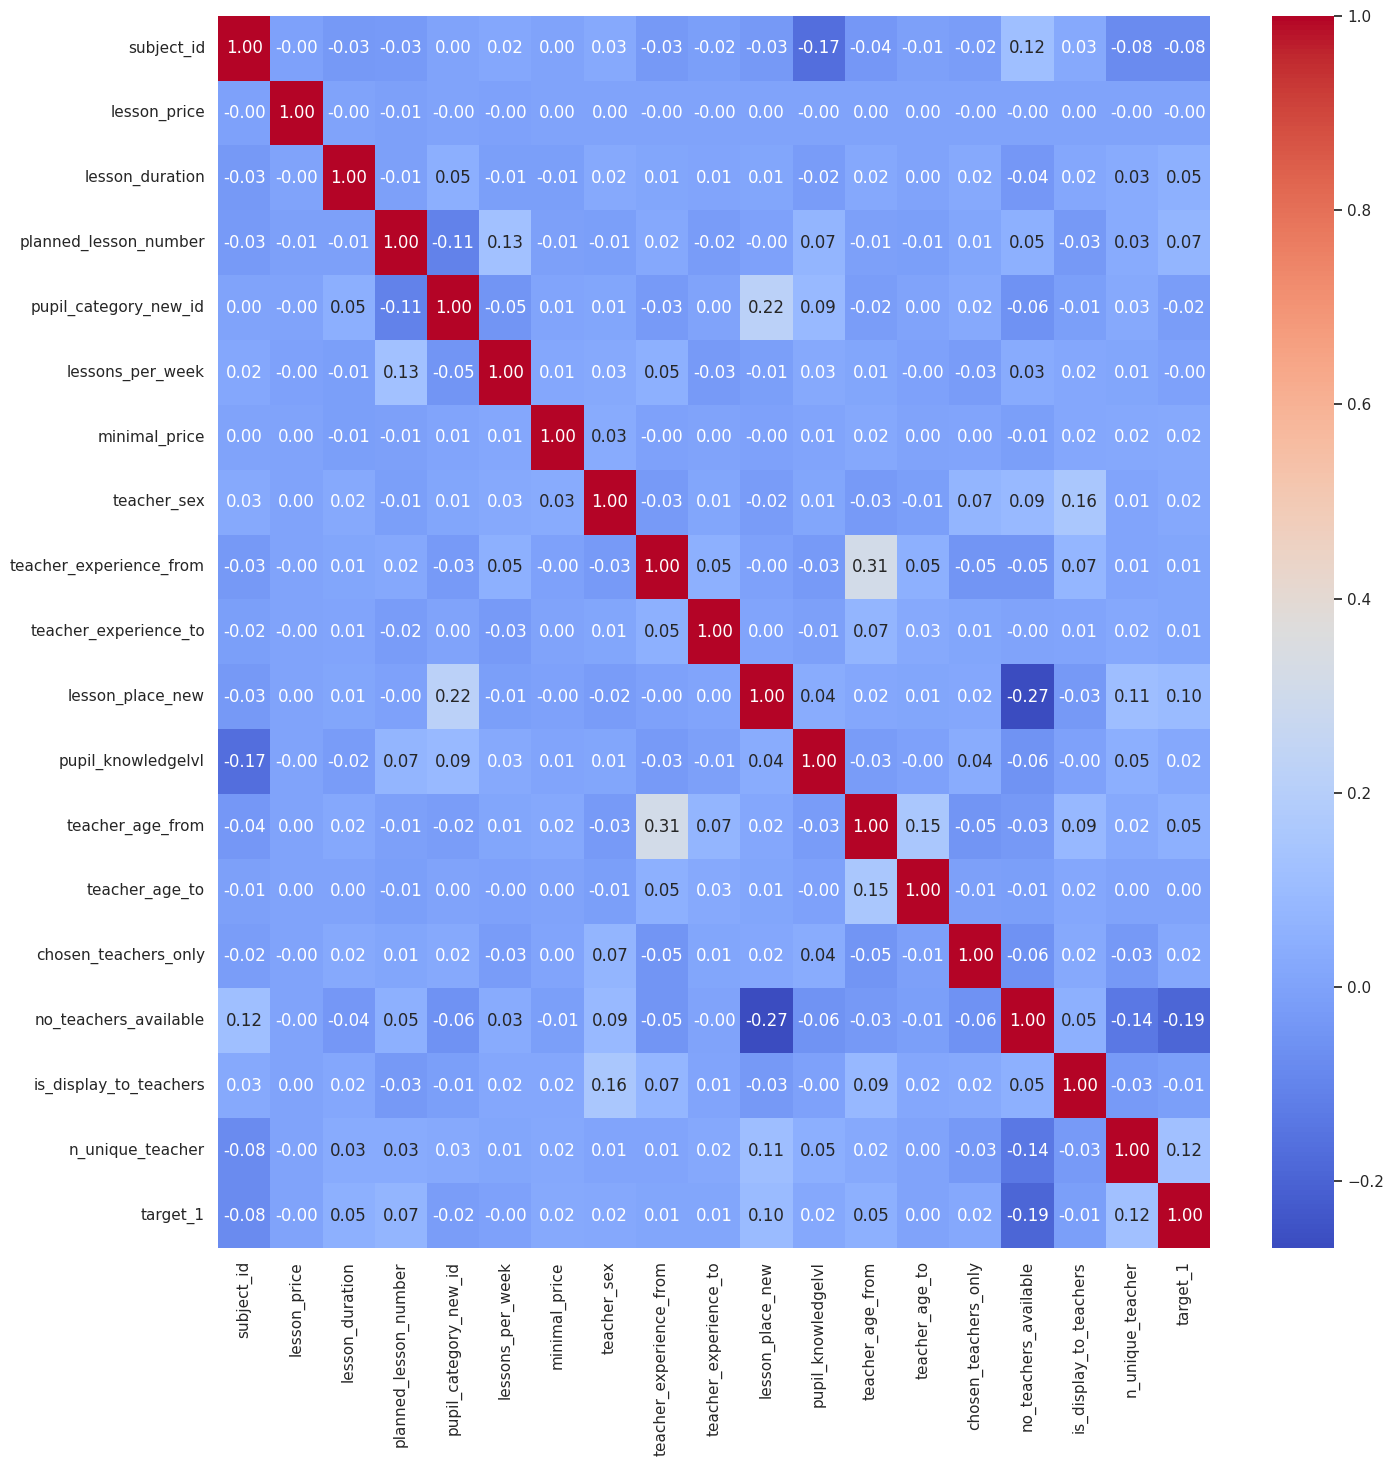

In [ ]:
#проверка лин корреляции Пирсона

correl = orders.corr()

sns.set(rc={"figure.figsize":(16, 16)})
dataplot=sns.heatmap(correl,
                     annot=True,
                     fmt=".2f",
                     cmap= 'coolwarm',
                     xticklabels=correl.columns,
                     yticklabels=correl.columns)

## разработка новых синтетических признаков

In [ ]:
#пока решил не добавлять новые признаки

In [ ]:
orders[:,:-1].head()

subject_id,lesson_price,lesson_duration,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,n_unique_teacher
f32,i32,i32,i32,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,i8,u32
21.0,800,60,7,14.0,2,0,3,0,0,4,0,0,0,0,0,1,1
21.0,3000,60,10,14.0,5,2000,3,0,0,4,0,0,0,0,0,1,1
8.0,1500,60,10,9.0,2,0,3,0,0,1,0,0,0,0,0,1,1
9.0,1500,60,1,14.0,2,0,3,0,0,2,0,0,0,0,0,1,1
8.0,1000,90,10,11.0,5,0,3,1,0,4,0,20,50,0,0,1,3


## деление на выборки для обучения и теста

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    orders[:,:-1],
    orders['target_1'],
    test_size=0.2,
    stratify=orders['target_1'],
    random_state=STATE)

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((453474, 18), (113369, 18), (453474,), (113369,))

In [ ]:
y_train.mean(), y_valid.mean()

(0.21288320829860147, 0.21288006421508526)

## выбор и обучение моделей

In [ ]:
#функция для расчета ROC_AUC и построения графика ROC-кривая

def rock(features, target, model):
    #
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = roc_auc_score(target, probabilities_one_valid)

    print('ROC_AUC =', round(auc_roc, 4))

    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    plt.figure()
    plt.figure(figsize=(8,6))

    plt.plot(fpr, tpr)

    #ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1.0], [0, 1.0], linestyle='--')

    #установка границ осей от 0 до 1
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    #подписи осей "False Positive Rate" и "True Positive Rate" >
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    #заголовок к графику "ROC-кривая"
    plt.title('ROC-кривая')
    plt.show();


#### RandomForestClassifier


In [ ]:
'''
def objective(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 20, 100),
            #'criterion': trial.suggest_categorical('criterion', ['log_loss']),
            'max_depth': trial.suggest_int('max_depth', 2, 100),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        }


    clf = RandomForestClassifier(random_state=STATE, **params)

    clf.fit(x_train, y_train)

    pred = clf.predict_proba(x_valid)[:,1]
    roc_auc = roc_auc_score(y_valid, pred)

    return roc_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=14)

'''

'\ndef objective(trial):\n    params = {\n            \'n_estimators\': trial.suggest_int(\'n_estimators\', 20, 100),\n            #\'criterion\': trial.suggest_categorical(\'criterion\', [\'log_loss\']),\n            \'max_depth\': trial.suggest_int(\'max_depth\', 2, 100),\n            \'min_samples_split\': trial.suggest_int(\'min_samples_split\', 2, 20),\n            \'min_samples_leaf\': trial.suggest_int(\'min_samples_leaf\', 1, 20),\n        }\n\n\n    clf = RandomForestClassifier(random_state=STATE, **params)\n\n    clf.fit(x_train, y_train)\n\n    pred = clf.predict_proba(x_valid)[:,1]\n    roc_auc = roc_auc_score(y_valid, pred)\n\n    return roc_auc\n\nstudy = optuna.create_study(direction="maximize")\nstudy.optimize(objective, n_trials=14)\n\n'

In [ ]:
try:
    print("Best trial:", study.best_trial.number)
    print("Best accuracy:", study.best_trial.value)
    print("Best hyperparameters:", study.best_params)
except:
    None


In [ ]:
#использование ранее подобранных гиперпараметров
try:
    params = study.best_params
except:
    params = {'n_estimators': 83, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 20}

rf = RandomForestClassifier(**params,
                            random_state=STATE,
                            #class_weight='balanced'
                            )

In [ ]:
%%time
rf.fit(x_train, y_train)

CPU times: user 53 s, sys: 162 ms, total: 53.2 s
Wall time: 54.6 s


RandomForestClassifier(max_depth=49, min_samples_leaf=20, min_samples_split=17,
                       n_estimators=83, random_state=33443)

ROC_AUC = 0.7452


<Figure size 1600x1600 with 0 Axes>

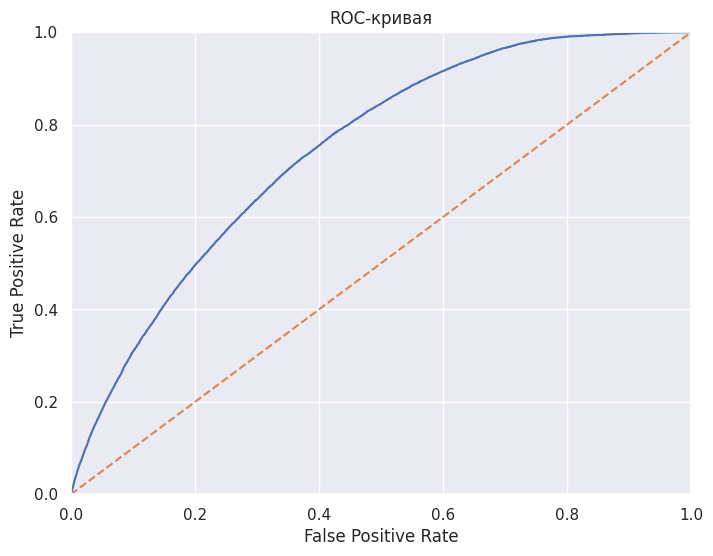

In [ ]:
#расчет ROC_AUC через вероятности классов и построение графика ROC - кривой
rock(x_valid, y_valid, rf)

In [ ]:
x_valid_pd = pd.DataFrame(x_valid.sample(n=1000, seed=STATE), columns=x_valid.columns)
explainer = shap.TreeExplainer(rf, x_valid_pd)
shap_values_scaled = explainer.shap_values(x_valid_pd)


100%|===================| 1990/2000 [04:00<00:01]       

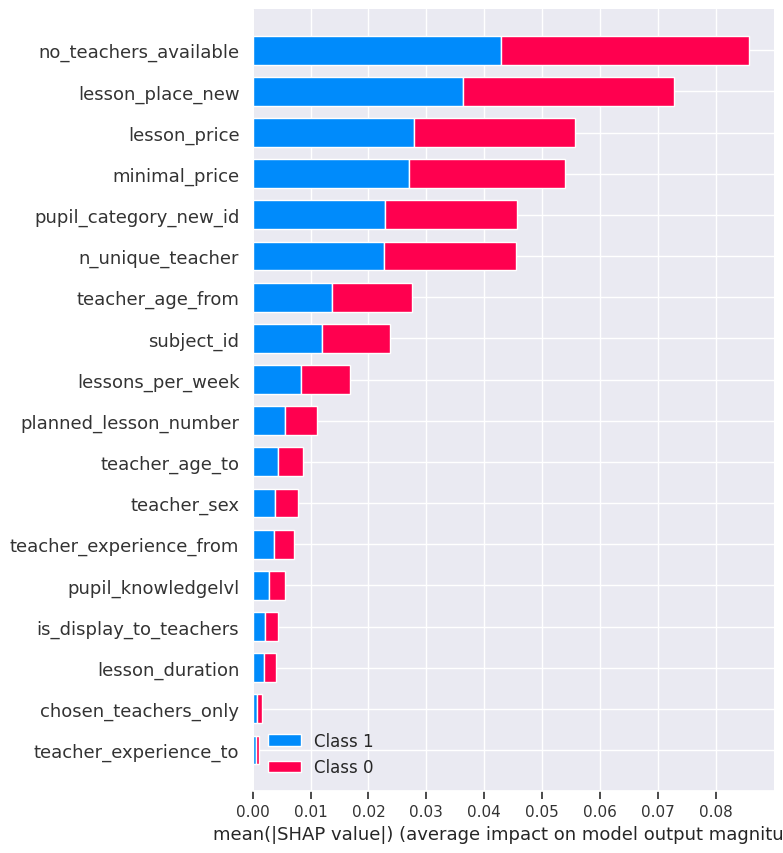

In [ ]:
shap.summary_plot(shap_values_scaled, x_valid_pd)

#### LogReg

In [ ]:
params = {'C':[1,10]}
lr = LogisticRegression()
clf = GridSearchCV(lr, params, scoring='roc_auc', cv=3, n_jobs=-1)

In [ ]:
%%time
clf.fit(x_train, y_train)

CPU times: user 10.8 s, sys: 3.86 s, total: 14.6 s
Wall time: 35.3 s


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10]}, scoring='roc_auc')

In [ ]:
clf.best_score_, clf.best_params_

(0.5842459736929194, {'C': 1})

In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

ROC_AUC = 0.5851


<Figure size 1600x1600 with 0 Axes>

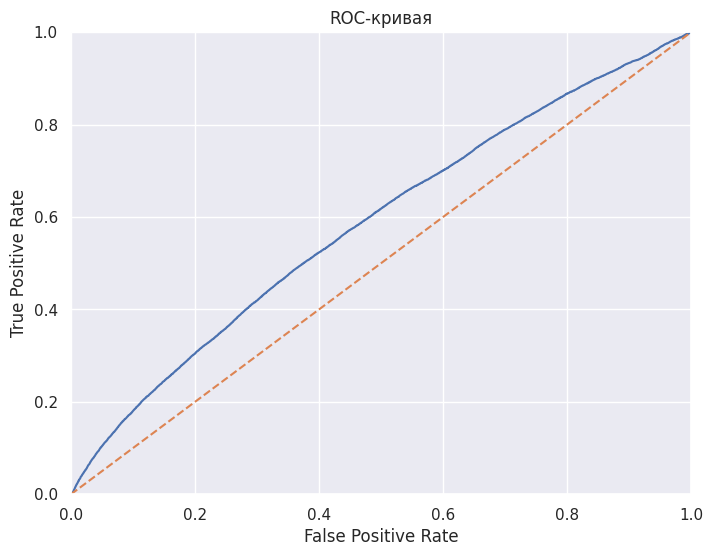

In [ ]:
#расчет ROC_AUC через вероятности классов и построение графика ROC - кривой
rock(x_valid, y_valid, lr)

#### CatBoost

In [ ]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_valid_np = np.array(x_valid)
y_valid_np = np.array(y_valid)

In [ ]:
cb = CatBoostClassifier(iterations=1000,
                        depth=8,
                        learning_rate=100.0e-3,
                        loss_function='Logloss',
                        random_seed=STATE,
                        eval_metric='AUC'
                           #verbose=True
                           )

In [ ]:
cb.fit(
    x_train_np, y_train_np,
    #cat_features=json_cat,
    eval_set=(x_valid_np, y_valid_np),
    metric_period=10,
    verbose=True,
    plot=False
)

0:	test: 0.7045271	best: 0.7045271 (0)	total: 225ms	remaining: 3m 45s
10:	test: 0.7245673	best: 0.7245673 (10)	total: 1.43s	remaining: 2m 8s
20:	test: 0.7307724	best: 0.7307724 (20)	total: 2.59s	remaining: 2m
30:	test: 0.7346995	best: 0.7346995 (30)	total: 3.84s	remaining: 2m
40:	test: 0.7374906	best: 0.7374906 (40)	total: 5.95s	remaining: 2m 19s
50:	test: 0.7392625	best: 0.7392625 (50)	total: 8.26s	remaining: 2m 33s
60:	test: 0.7404618	best: 0.7404618 (60)	total: 9.48s	remaining: 2m 26s
70:	test: 0.7415620	best: 0.7415620 (70)	total: 10.7s	remaining: 2m 20s
80:	test: 0.7424481	best: 0.7424481 (80)	total: 11.9s	remaining: 2m 14s
90:	test: 0.7430801	best: 0.7430801 (90)	total: 13.1s	remaining: 2m 10s
100:	test: 0.7439675	best: 0.7439675 (100)	total: 14.4s	remaining: 2m 7s
110:	test: 0.7444881	best: 0.7444881 (110)	total: 15.6s	remaining: 2m 4s
120:	test: 0.7451442	best: 0.7451442 (120)	total: 16.8s	remaining: 2m 2s
130:	test: 0.7456904	best: 0.7456904 (130)	total: 18.1s	remaining: 2m
14

In [ ]:
bestTest = 0.749785202

In [ ]:
#сохранение модели

patch = os.path.join(DATA_PATH_GOOGLE, 'cb_model_v0.pkl')
joblib.dump(cb, patch)

['/content/drive/MyDrive/Peton/hakaton_repetit_ru/cb_model_v0.pkl']

ROC_AUC = 0.7498


<Figure size 1600x1600 with 0 Axes>

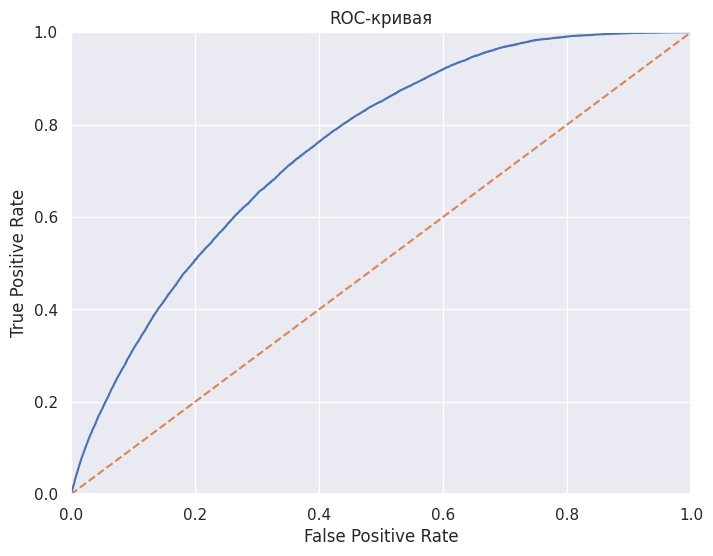

In [ ]:
#расчет ROC_AUC через вероятности классов и построение графика ROC - кривой
rock(x_valid_np, y_valid_np, cb)

### Метрика precision_score

In [ ]:
#для разных порогов от 0 до 1 с шагом 0.1
pred_proba = cb.predict_proba(x_valid_np)[:,:-1]

for tresh in np.arange(0,1,0.1):
    pred = pred_proba > tresh
    print('tresh =', round(tresh,2), 'precision =', round(precision_score(pred, y_valid_np), 4))

tresh = 0.0 precision = 1.0
tresh = 0.1 precision = 1.0
tresh = 0.2 precision = 0.9999
tresh = 0.3 precision = 0.9984
tresh = 0.4 precision = 0.9814
tresh = 0.5 precision = 0.908
tresh = 0.6 precision = 0.7433
tresh = 0.7 precision = 0.4843
tresh = 0.8 precision = 0.2041
tresh = 0.9 precision = 0.0361


### shap для CatBoost

In [ ]:
x_valid_pd = pd.DataFrame(x_valid.sample(n=1000, seed=STATE), columns=x_valid.columns)
explainer = shap.TreeExplainer(cb, x_valid_pd)
shap_values_scaled = explainer.shap_values(x_valid_pd)


 99%|===================| 988/1000 [01:19<00:00]       

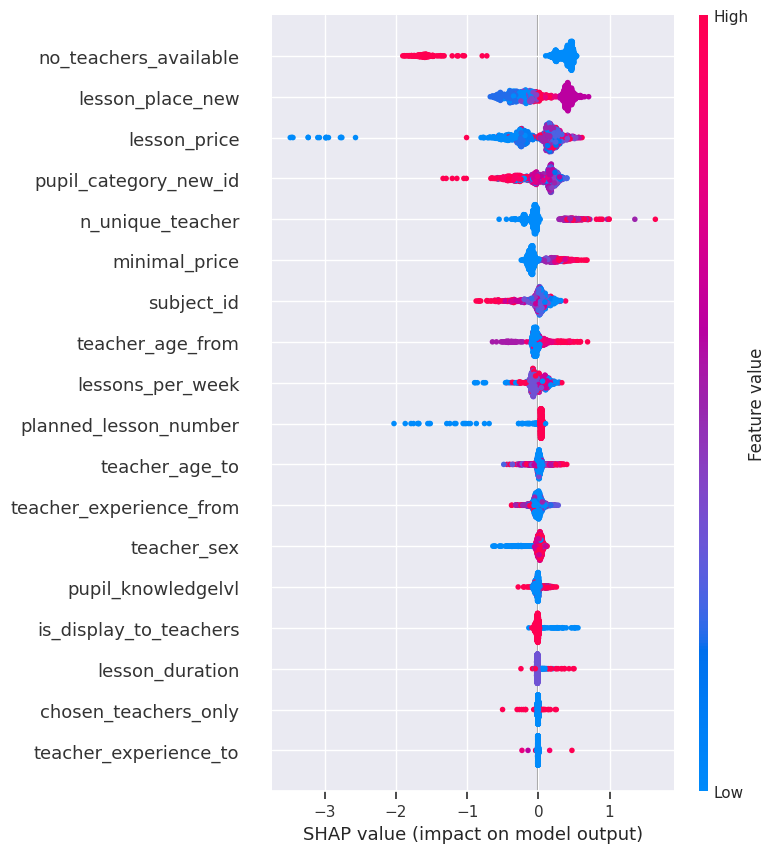

In [ ]:
shap.summary_plot(shap_values_scaled, x_valid_pd)


In [ ]:
x_valid.columns

['subject_id',
 'lesson_price',
 'lesson_duration',
 'planned_lesson_number',
 'pupil_category_new_id',
 'lessons_per_week',
 'minimal_price',
 'teacher_sex',
 'teacher_experience_from',
 'teacher_experience_to',
 'lesson_place_new',
 'pupil_knowledgelvl',
 'teacher_age_from',
 'teacher_age_to',
 'chosen_teachers_only',
 'no_teachers_available',
 'is_display_to_teachers',
 'n_unique_teacher']

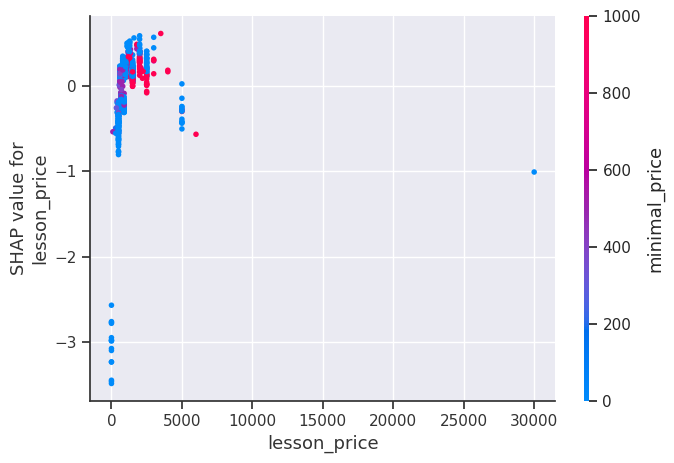

In [ ]:
#просмотр влияния для одного признака
shap.dependence_plot('lesson_price', shap_values_scaled, x_valid_pd)

## Распределение вероятностей


In [ ]:
preds = cb.predict_proba(x_valid_np)[:,:-1]
preds

array([[0.80373953],
       [0.66028661],
       [0.78526231],
       ...,
       [0.72299984],
       [0.83310859],
       [0.85564165]])

<Figure size 1600x1600 with 0 Axes>

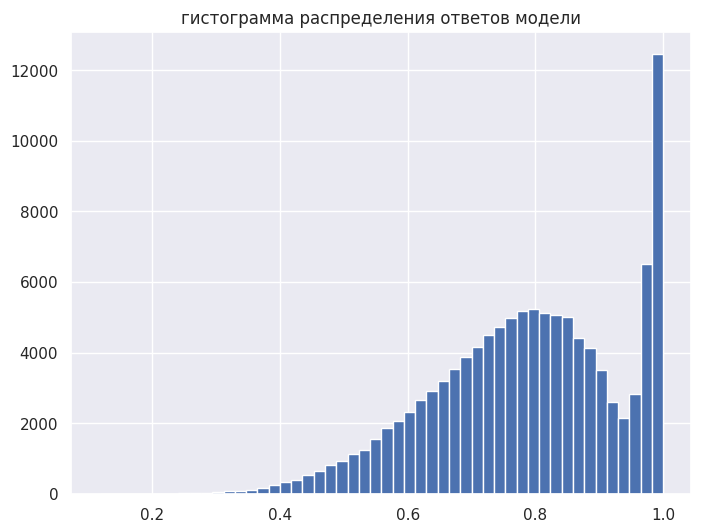

In [ ]:
plt.figure()
plt.figure(figsize=(8,6))

_ = plt.hist(preds, bins=50)
plt.title("гистограмма распределения ответов модели")

plt.show();

## выводы по исследованию

Проект выполнен с использованием только одной таблицы `orders`.
Получившаяся метрика roc_auc примерно 0.7498. для модели CatBoost.

Использовать другие таблицы я не решился, по разным причинам (возможная нехватка памяти, неясно как аггрегировать к заявке разных репетиторов...).

-- --
Для этого проекта собран докер контейнер, расположен тут
https://hub.docker.com/repository/docker/dronnet/repetit_dock/general

Сделан на основе streamlit. Для запуска контейнера можно ввести `docker run --rm -d --name REPETIT -p 8501:8501 id_образа`

В браузере, на http://localhost:8501 должна открыться страница проекта. Для получения предсказаний нужно загрузить файл такого же вида как и `orders.feather`. Или его часть, такой файл `orders_sample.feather`, для тестирования образа записывается в этом коде в ячейке [6].

Его и можно использовать для тестирования образа.